# Using other kNN libraries in Scanpy

Since Scanpy was released, there has been quite some development in the space of approximate nearest neighbor detection.

In our example, we’re going to use [annoy](https://github.com/spotify/annoy):

In [1]:
%pip install -qU pip
%pip install -q annoy scanpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Self, ClassVar as NoParameter

import numpy as np
import scipy.sparse as sp
import scanpy as sc

sc.logging.print_header()

scanpy==1.10.0rc2.dev6+g14555ba4.d20240304 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


Our nearest neighbors implementation uses the PCA embedding by default, so let’s pre-compute that:

In [3]:
adata_default = sc.datasets.paul15()
sc.pp.pca(adata_default)
adata_annoy, adata_pynnd = adata_default.copy(), adata_default.copy()

The best way to use a third-party approximate nearest neighbors implementation is to use [sklearn-ann](https://github.com/scikit-learn-contrib/sklearn-ann),
which will soon be on PyPI. It provides so-called *kNN Transformer classes*.

For illustration purposes, we’re going to implement one.

The class needs two methods: `get_params` and `fit_transform`.
We start with just the data container for the kNN parameters:

In [4]:
from dataclasses import dataclass
from annoy import AnnoyIndex


@dataclass
class AnnoyTransformerBase:
    n_neighbors: int
    # Add other parameters here, like `metric`, ...

    _index: NoParameter[AnnoyIndex | None] = None

Next comes the `fit` part of `fit_transform`.
In our case, we build Annoy’s search index:

In [5]:
def fit(self: AnnoyTransformerBase, data: np.ndarray) -> Self:
    self._index = AnnoyIndex(data.shape[1], "euclidean")
    for i, v in enumerate(data):
        self._index.add_item(i, v)
    self._index.build(n_trees=10, n_jobs=4)
    return self

Now the `transform` part returning a kNN graph repressented as a sparse matrix.

In a real implementation (like in `sklean-ann`), this would handle a `data` parameter.
We ignore the data parameter and expect it to be the same as for `fit`.
That way, we always retun a n×n matrix.

In [6]:
def transform(self: AnnoyTransformerBase, data: object) -> sp.csr_matrix:
    if self._index is None:
        raise RuntimeError("Transformer not fitted yet")
    n_samples = self._index.get_n_items()

    # For compatibility reasons, as each sample is considered as its own
    # neighbor, one extra neighbor will be computed.
    n_neighbors = self.n_neighbors + 1

    indices = np.empty((n_samples, n_neighbors), dtype=int)
    distances = np.empty((n_samples, n_neighbors))

    for i in range(self._index.get_n_items()):
        ind, dist = self._index.get_nns_by_item(
            i, n_neighbors, -1, include_distances=True
        )

        indices[i], distances[i] = ind, dist

    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    kneighbors_graph = sp.csr_matrix(
        (distances.ravel(), indices.ravel(), indptr),
        shape=(n_samples, n_samples),
    )

    return kneighbors_graph

Finally, we tie it all together. We add the required `get_params` method.

`TransformerMixin` provides the `fit_transform(data)` method by simply chaining `self.fit(data).transform(data)`.

In [7]:
from dataclasses import asdict

from sklearn.base import TransformerMixin


class AnnoyTransformer(AnnoyTransformerBase, TransformerMixin):
    get_params = asdict
    fit = fit
    transform = transform


# Check if get_params works:
AnnoyTransformer(15).get_params()

{'n_neighbors': 15}

Now let’s compare our ad-hoc transformer with Scanpy’s defaults.
For small datasets, Scanpy uses a shortcut.
`transformer="pynndescent"` makes sure the shortcut is not used.

In [8]:
%timeit -o sc.pp.neighbors(adata_default, n_neighbors=15)
%timeit -o sc.pp.neighbors(adata_pynnd, transformer="pynndescent", n_neighbors=15)
%timeit -o sc.pp.neighbors(adata_annoy, transformer=AnnoyTransformer(15))

29.7 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.27 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
67.2 ms ± 685 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 67.2 ms ± 685 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

Looks like Annoy is quite a bit faster than PyNNDescent (but of course not as fast as Scanpy’s shortcut on a small dataset like this).

Let’s see if Leidenalg and UMAP get reasonable results when using each of the kNN graphs.

In [9]:
for adata in [adata_default, adata_annoy, adata_pynnd]:
    sc.tl.leiden(adata, flavor="igraph")
    sc.tl.umap(adata)

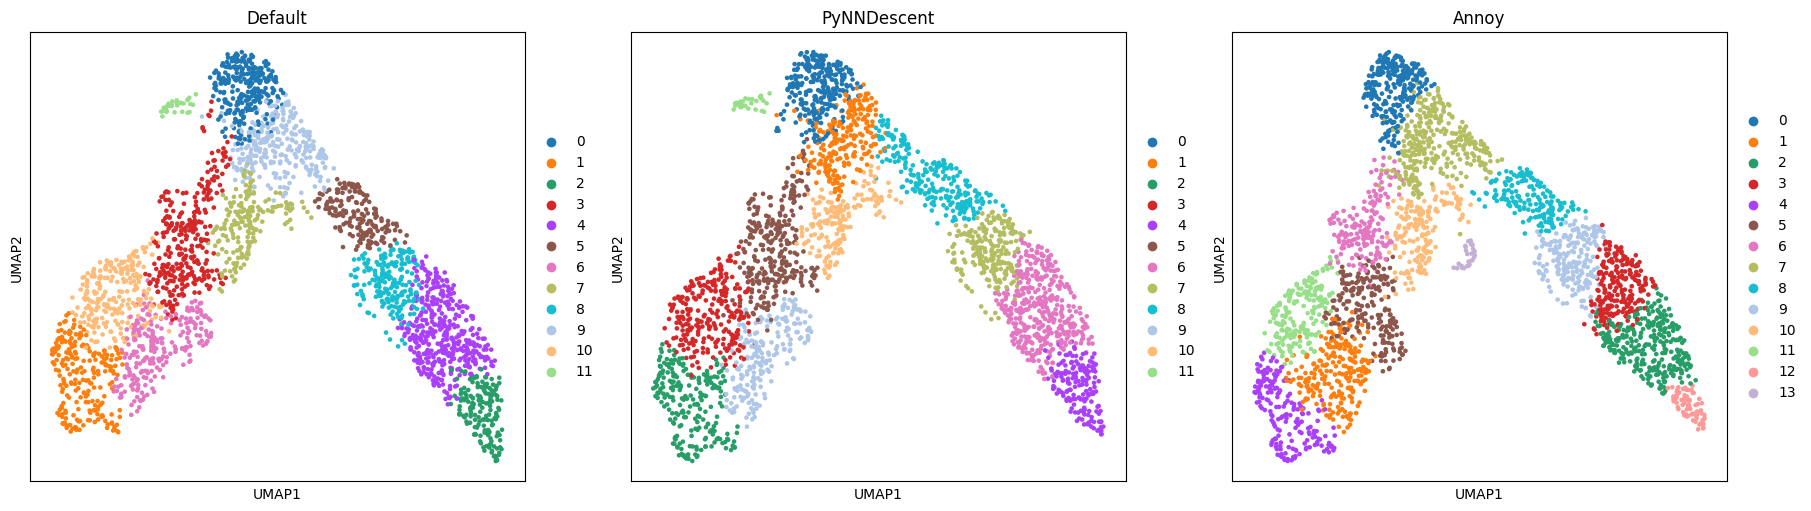

In [11]:
import matplotlib.pyplot as plt

with plt.ioff():
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), layout="constrained")
sc.pl.umap(adata_default, color="leiden", ax=axs[0], show=False, title="Default")
sc.pl.umap(adata_pynnd, color="leiden", ax=axs[1], show=False, title="PyNNDescent")
sc.pl.umap(adata_annoy, color="leiden", ax=axs[2], show=False, title="Annoy")
fig

The results look sensible enough!